In [55]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import mdtraj as md
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from importlib import reload
from cycler import cycler
from itertools import chain
from functools import partial
# source modules and classes being developed 
from writhe_tools.writhe import (Writhe,
                                 to_writhe_matrix,
                                 calc_writhe_parallel,
                                 get_segments)


from writhe_tools.plots import (subplots_fes2d,
                                subplots_proj2d,
                                proj2d,
                                fes2d,
                                get_color_list,
                                box_plot,
                                build_matrix_boxplot_grid)

from writhe_tools.tcca import CCA, tCCA

from matplotlib.lines import Line2D

from writhe_tools.stats import Kmeans, rotate_points


from writhe_tools.md_tools import (ResidueDistances,
                                   get_residues,
                                   calc_rsa,
                                   calc_sa,
                                   traj_slice,
                                   load_traj,
                                   plot_distance_matrix,
                                   residue_distances,
                                   one_hot_residue_type,
                                   to_contacts
                                    )

from writhe_tools.md_tools import one_hot_residue_type as one_hot

from writhe_tools.utils import (lsdir,
                                group_by,
                                indices_stat,
                                sort_by_val_in,
                                reindex_list,
                                sort_indices_list,
                                load_array_dir,
                                filter_strs, 
                                contiguous_bool,
                                to_numpy,
                                one_hot,
                                num_str,
                                load_dict,
                                save_dict,
                                product
                                )

from writhe_tools.msm_tools import MarkovModel

from typing import Dict, List, Tuple

from writhe_tools.stats import pmf

import warnings
warnings.filterwarnings("ignore")


path = "/data/r1r2"
epi_dir = f"{path}/epi002"
apo_dir = f"{path}/apo"
cam_dir = f"{path}/cam1"
paths = [apo_dir, epi_dir, cam_dir]
labels = ['APO', 'EPI-002', '1aa']

protein_files = ['/data/r1r2/apo/protein.100us.dcd',
                 '/data/r1r2/epi002/protein.100us.dcd',
                 '/data/r1r2/cam1/protein.85us.dcd']


ligand_files = [lsdir(i, keyword=['dcd', 'ligand'], exclude=['wrap'], match=all)[0] for i in paths[1:]]
protein_pdb = '/data/r1r2/epi002/R2_dimer.pdb'
ligand_pdbs = [
               '/data/r1r2/epi002/R2_dimer.epi002.rename.pdb',
               '/data/r1r2/cam1/protein.ligand.pdb',
               ]
helix_pdb = '/data/r1r2/monomer_r1r2_helix.pdb'

trunc = .3
pre_trunc = .3
state_width = .8
state_font_scale = 1.5


fes2d_args = dict(
      cmap="coolwarm",
      bins=55,
      n_contours=8,
      contour_lines=True,
      alpha_lines=0.35,
      alpha_contours=0.6,
      mask=False,
      scatter=True,
      scatter_alpha = .15,
      scatter_size=.05,
      scatter_stride=50,
      scatter_max=.35,
      scatter_min=.15,
      scatter_cmap="coolwarm",
      hide_ax=False,
      extend_border=0.1,
    )

from functools import reduce
from functools import partial

def fill_1d(x, values, indices):
    x[indices] = values
    return x

def prod(vectors, sum_=False):
    if sum_:
        vectors = [v.sum(axis=-1) for v in vectors]
    return reduce(np.multiply, vectors)

split = partial(np.array_split, indices_or_sections=2, axis=-1) 

ternary_bool = lambda distances : prod([to_contacts(i, 1).any(1) for i in split(distances)])

import scipy
import numpy as np
from typing import Tuple

def bootstrap(data: np.ndarray,
              confidence_level: float = 0.68,
              n_resamples: int = 500,
              method: str = "percentile") -> Tuple[float, float]:
    """
    Bootstrap binary data to get the mean and an intentionally wide error estimate.

    Parameters:
        data: binary array of 0s and 1s
        confidence_level: typically 0.99 for wider intervals
        n_resamples: lower values increase variability (default 500)
        method: use 'percentile' to produce wider CIs

    Returns:
        mean: estimated mean of the binary array
        error: half-width of the confidence interval
    """

    res = scipy.stats.bootstrap((data,), statistic=np.mean,
                    confidence_level=confidence_level,
                    n_resamples=n_resamples,
                    method=method,
                    random_state=0)

    mean = np.mean(data)
    error = (res.confidence_interval.low, res.confidence_interval.high, ) 
    return [mean, error]


from pyblock.blocking import reblock, find_optimal_block
from collections import Counter
def block_error(x: np.ndarray, lower_upper: bool = False):
    """
    x : (d, N) numpy array with d features and N measurements
    """
    n = x.shape[-1]
    blocks = reblock(x)
    optimal_indices = np.asarray(find_optimal_block(n, blocks))
    isnan = np.isnan(optimal_indices)
    #mode = Counter(optimal_indices[~isnan].astype(int)).most_common()[0][0]
    optimal_indices[isnan] = -1 # biggest block
    optimal_indices=optimal_indices.astype(int)
    #op
    #print(optimal_indices[0])
    if x.ndim == 1:
        return lu_from_error(x.mean(), blocks[optimal_indices[0]].std_err.item()) if lower_upper else\
                (x.mean(), blocks[optimal_indices[0]].std_err.item())
    else:
        return lu_from_error(x.mean(-1), np.asarray([blocks[i].std_err[j] for j, i in enumerate(optimal_indices.astype(int))]))\
                if lower_upper else (x.mean(-1), np.asarray([blocks[i].std_err[j] for j, i in enumerate(optimal_indices.astype(int))]))

def lu_from_error(mean, error):
    if all(isinstance(i, (float, int)) for i in (mean, error)):
        mean, error = [mean], [error]
    return np.array([[mu - err, mu + err] for mu, err in zip(mean, error)])

#block_error(np.arange(10000), lower_upper=False)
   


# Computations

In [65]:
# protein only calculations
label = 'APO'
ca_selection = md.load(protein_pdb).top.select('name CA')
sequence, ca_index = get_residues(md.load(protein_pdb))
# 1 letter codes for the monomer sequence (just 1)
codes = np.array(list(md.load(protein_pdb).top.to_fasta()[0]))[:24]

unitcell_lengths = md.load(protein_files[0], top=protein_pdb).unitcell_lengths


ca_distances = ResidueDistances(index_0=np.arange(24),
                                index_1=np.arange(24, 48),
                                traj=md.load(protein_files[0], top=protein_pdb, atom_indices=ca_selection)
                               )

# dimer events from ca_distances
dimer = ca_distances.contacts(1).any(1)
dimer_events = contiguous_bool(bools=dimer)
lengths = 0.24 * np.fromiter(map(len, dimer_events), float) # scale by physical time

# sort by event length
sort = lengths.argsort()[::-1]
dimer_events = reindex_list(dimer_events, sort)
lengths = lengths[sort]

# structural features
sa = np.stack([calc_sa(md.load(protein_files[0], top=protein_pdb, atom_indices=j), helix_pdb) for j in split(ca_selection)])

dssp = np.where(md.compute_dssp(traj=md.load(protein_files[0], top=protein_pdb)) == 'H', 1, 0)[:, ca_index]

writhe = Writhe(xyz=md.load(protein_files[0], top=protein_pdb, atom_indices=ca_selection).center_coordinates().xyz)
writhe_segments = [get_segments(index0=np.arange(24)),
                   get_segments(index0=np.arange(24, 48)),
                   get_segments(index0=np.arange(24), index1=np.arange(24, 48))
                  ]
writhe_features = np.concatenate([writhe.compute_writhe(segments=s,
                                                        cuda=True,
                                                        store_results=False,
                                                        #lengths=unitcell_lengths,
                                                       )['writhe_features']
                                  for s in writhe_segments], axis=-1)

# dimensionality reduction
tcca = tCCA(writhe_features, lag=10, dim=2,).fit()

# compute the projection and then align to a reference because eigen vects might have flipped sign
proj = tcca.transform(writhe_features); proj = rotate_points(np.load(lsdir(paths[0], keyword='writhe_tcca_lag_')[0])[1:, :2],
                                                             proj, so3=False)

# to cluster with Kmeans
# dtraj, frames_cl = Kmeans(proj, n_clusters=7, n_dim=2)

# Kmeans isn't deterministic, so we use a pre computed clustering to keep consistency with reported values

## WARNING - MUST HAVE REFERNECE AVAILABLE FOR THIS TO WORK - CAN JUST COMMENT THIS OUT AND RECLUSTER USING LINES ABOVE
dtraj = load_dict('density_clusters.pkl')[0]; frames_cl = group_by(dtraj)
centroids = group_by(dtraj, proj, reduction = partial(np.mean, axis = 0))


 # Visualize latent space

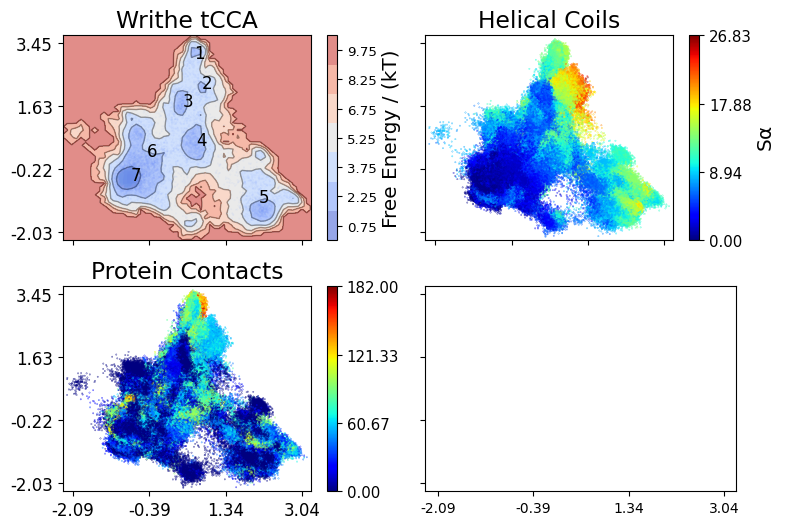

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5.4), sharey=True, sharex=True)
ax=ax.flat
fes2d(proj, cluster_centers=centroids, ax=ax[0],
      **fes2d_args, title='Writhe tCCA', font_scale=1.2)

# proj2d(proj, 
#        ax=ax[1],
#        c=to_contacts(np.load(f'{paths[1]}/ligand_distances.npy'), 0.6).sum(-1),
#        cmap=gray_to_color_cmap(),
#        title = 'Ligand Contacts',
#        font_scale=1.2)

proj2d(proj,  ax=ax[1], c=sa.sum((0,2)),
       cmap='jet', title = 'Helical Coils',
       font_scale=1.2,dot_size=.05,
       vmin=0, cbar_label=r'S$\alpha$')

proj2d(proj, 
       ax=ax[2],
       c=ca_distances.contacts(1).sum(-1),
       cmap='jet',
       title = 'Protein Contacts',
       font_scale=1.2,
       vmin=0,
       dot_size=.05)

fig.tight_layout()
fig.savefig('apo_projections.png', bbox_inches='tight', dpi=1000)


 # protein contacts (CA-CA distance < 1 nm) and helical propensities (DSSP algorithm)

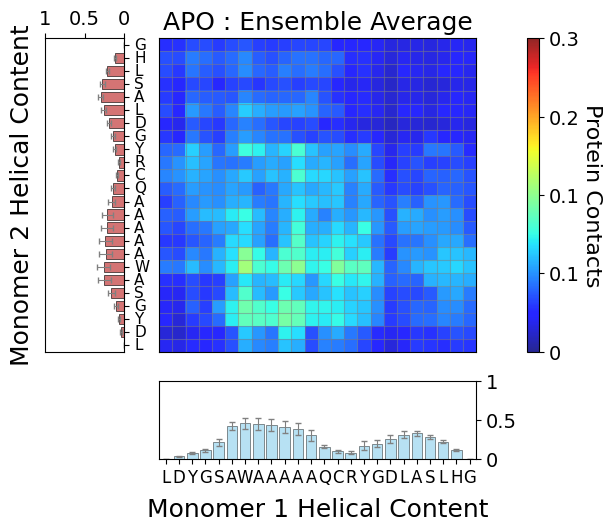

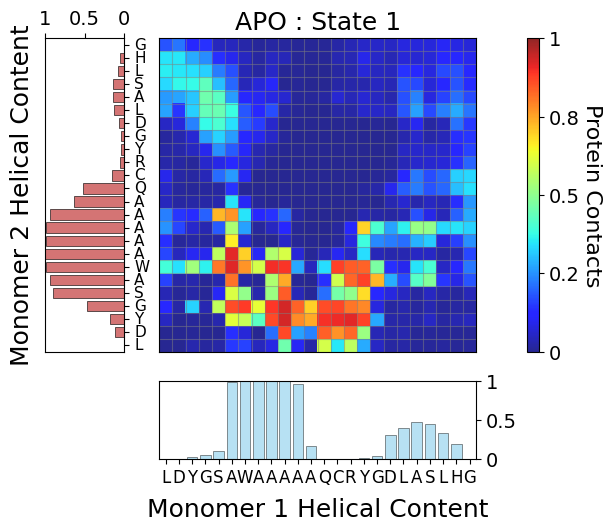

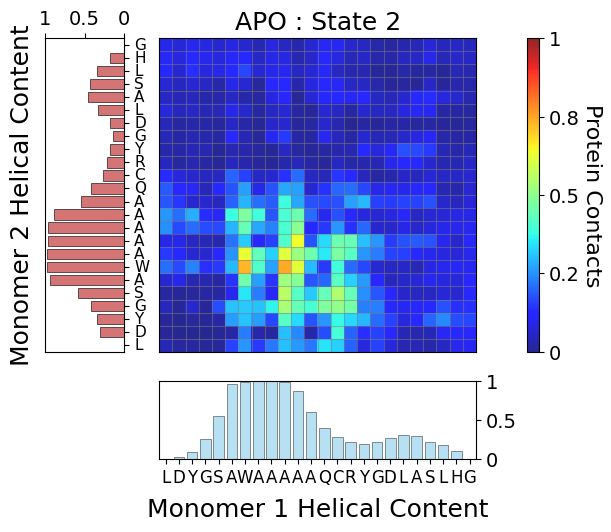

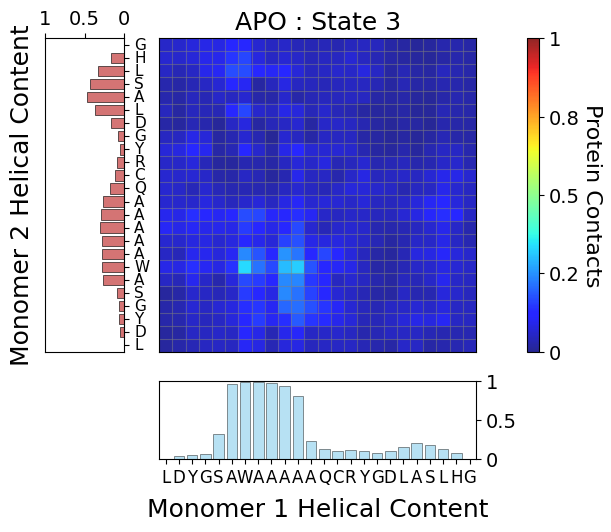

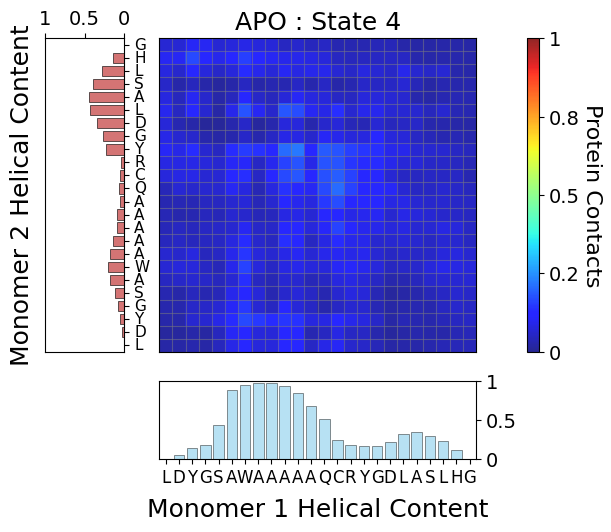

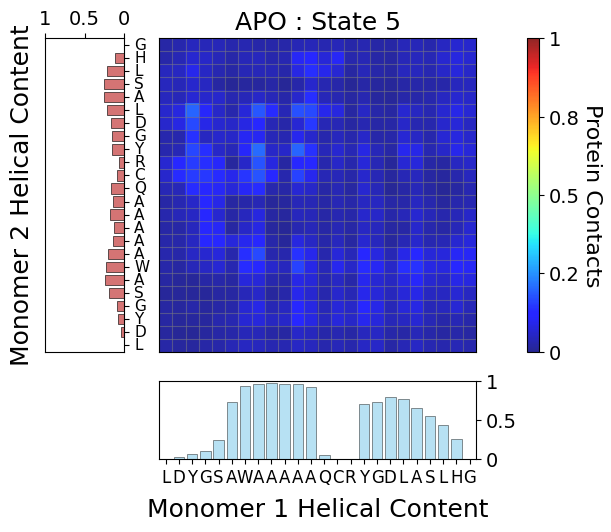

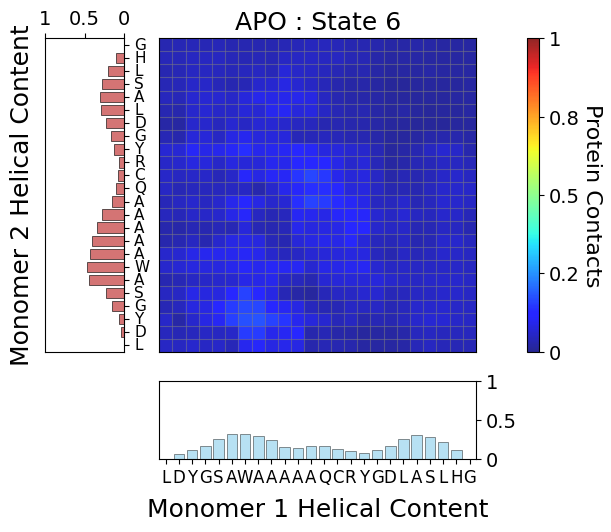

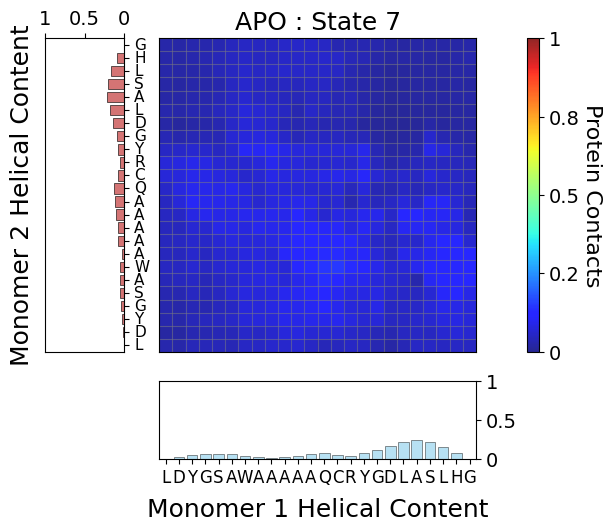

In [74]:
import writhe_tools
reload(writhe_tools)
reload(writhe_tools.plots)
from writhe_tools.plots import build_matrix_boxplot_grid

dssp_error = split(block_error(dssp.T)[1])
build_matrix_boxplot_grid(ca_distances.matrix(contacts=True, cut_off=1).mean(0).T,
                          dssp[:,:24].mean(0),
                          dssp[:,24:].mean(0),
                          bottom_errors=dssp_error[0],
                          left_errors=dssp_error[1],
                          cmap='jet',
                          title=f'{label} : Ensemble Average',
                          bottom_title='Monomer 1 Helical Content',
                          vmin=0,
                          vmax=.3,
                          marginal_max=1,
                          left_title='Monomer 2 Helical Content',
                          cbar_label='Protein Contacts',
                          ticks=codes,
                          ecolor='gray'
                          #path=f'{paths[i]}/protein_protein_helix_ensemble_same_bounds.png'
                         )
for i, frames in enumerate(frames_cl):
    build_matrix_boxplot_grid(ca_distances.matrix(contacts=True, cut_off=1, index=frames).mean(0).T,
                          dssp[frames, :24].mean(0),
                          dssp[frames, 24:].mean(0),
                          cmap='jet',
                          title=f'{label} : State {i+1}',
                          bottom_title='Monomer 1 Helical Content',
                          vmin=0,
                          vmax=1,
                          marginal_max=1,
                          left_title='Monomer 2 Helical Content',
                          cbar_label='Protein Contacts',
                          ticks=codes,
                          #path=f'{paths[i]}/protein_protein_helix_ensemble_same_bounds.png'
                         )
    


Text(0.5, 1.0, 'Event Protein Contact distributions')

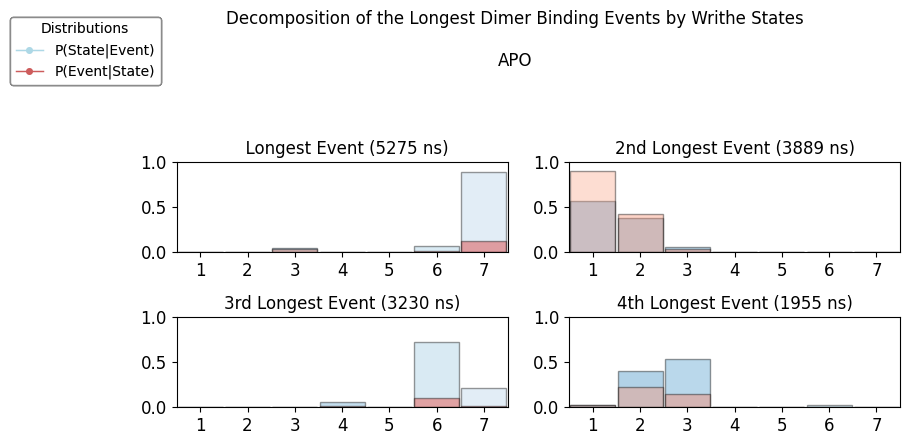

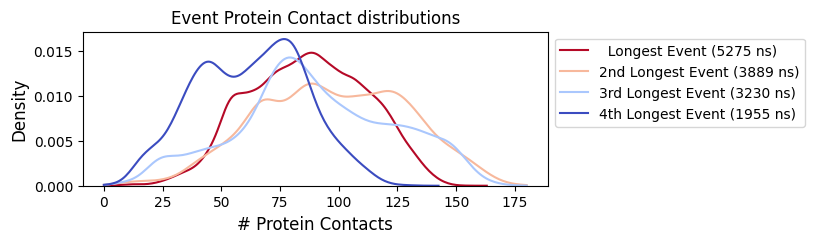

In [45]:
import seaborn as sns
fig, axes = plt.subplots(2,2, figsize=(8, 4))
event_title = dict(zip([0, 1, 2, 3], ' ,2nd,3rd,4th'.split(',')))
for i, (frames, length, ax) in enumerate(zip(dimer_events, lengths, axes.flat)):

    cSE = pmf(dtraj[frames], np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    cS =  pmf(dtraj, np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    pES = cSE / cS
    pSE = cSE / cSE.sum()
    
    box_plot(pSE, label_stride=1, cmap='Blues_r',
             ax=ax, alpha=.4, labels=np.arange(len(pES))+1,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)
    
    box_plot(pES, label_stride=1, cmap='Reds',
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Populaton", 
             labels=np.arange(len(pES))+1,
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1,
            title = f'{event_title[i]} Longest Event ({length:.0f} ns)')
    
    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=l,
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, (l, color) in enumerate(zip(["P(State|Event)", "P(Event|State)"],
                                                 ["lightblue", "indianred"]))]
    
    fig.legend(handles=legend_elements,title="Distributions",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=1,
           bbox_to_anchor = [-.14,1.1])
    
    fig.suptitle(f"Decomposition of the Longest Dimer Binding Events by Writhe States\n\n{label}", y=1.1)

fig.tight_layout()




fig, ax = plt.subplots(1, 1, figsize=(6,2))
for i, (frames, length, color) in enumerate(zip(dimer_events[:4], lengths, get_color_list(4,'coolwarm_r'))):
    
    sns.kdeplot(ca_distances.contacts(1)[frames].sum(-1),
                label=f'{event_title[i]} Longest Event ({length:.0f} ns)',
                common_grid=True,
                ax=ax,
                clip=(0,180),
                color=color)

ax.legend(ncol=1, bbox_to_anchor=[1,1])
ax.set_xlabel('# Protein Contacts', size=12)
ax.set_ylabel('Density', size=12)
ax.set_title('Event Protein Contact distributions', 
                #size=15,
               )

In [54]:
import pandas
from pandas import DataFrame
from IPython.display import display, Markdown
cols = ['Population %', r'Protein Contacts',  r'$S\alpha$', 'Dimer %', 'Ligand Contacts', 'Ternary %']

rows = []

rows.append(group_by(dtraj, reduction=lambda x : 100 * x.sum() / len(dtraj)))

rows.append(group_by(dtraj,
                    ca_distances.contacts(1).sum(-1),
                    np.mean))


rows.append(group_by(dtraj, sa.sum((0, 2)), np.mean))

rows.append(100 * group_by(dtraj,
                           dimer,
                           np.mean))


display(Markdown(f'{label} State Averaged Observables'))
display(pandas.DataFrame(np.array(rows).T.round(1), columns=cols[:4], index=np.arange(1, len(rows[0]) + 1)))
        
    

APO State Averaged Observables

,Population %,Protein Contacts,$S\alpha$,Dimer %
1,2.5,98.3,13.0,99.0
2,3.4,73.2,15.3,98.7
3,7.1,37.4,7.8,72.6
4,12.6,41.0,9.1,72.5
5,12.6,30.9,10.2,61.4
6,22.7,33.1,5.1,56.1
7,39.2,34.7,2.0,61.8
